In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [52]:
data = pd.read_csv(r'D:\All Projects\Stock Prediction\content\all_stocks_5yr.csv')
print(data.shape)
data.sample(7)

(619040, 7)


,date,open,high,low,close,volume,Name
284629,2014-10-28,68.40,68.99,67.64,68.35,762372,HRS
257621,2013-04-12,148.40,149.60,147.01,149.12,3131338,GS
75244,2017-07-14,61.28,62.25,61.21,62.11,1951282,BAX
604239,2014-04-30,120.39,120.81,117.82,119.12,968003,XEC
488442,2014-07-18,48.98,49.50,48.69,49.43,718894,RMD
287438,2015-12-23,15.48,15.96,15.41,15.96,7589671,HST
45036,2017-09-27,146.24,148.50,146.01,147.91,927744,AMP


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [54]:
#We notice that date isn't a datetime object so we convert it into one.
data['date']=pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


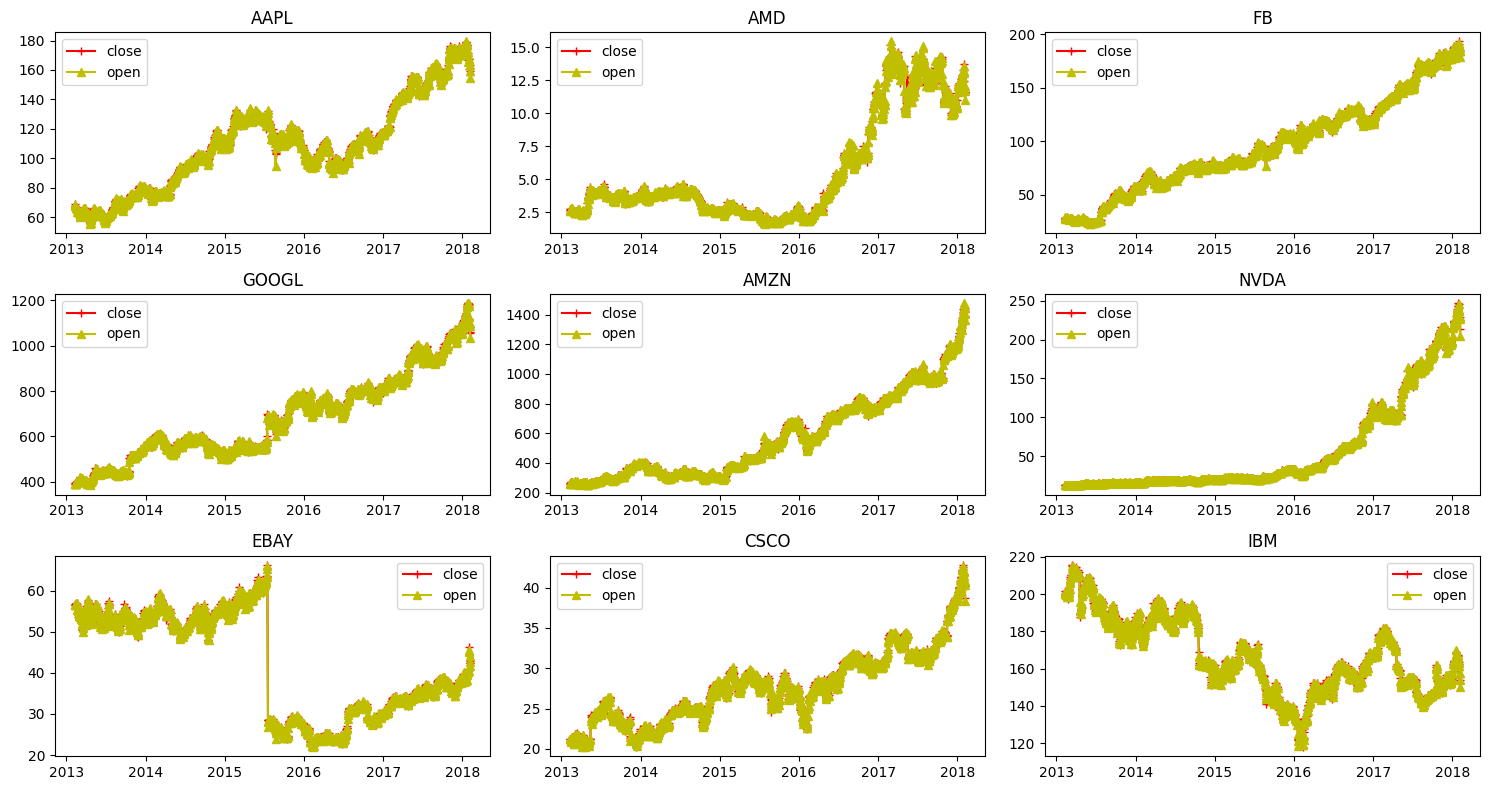

In [55]:
plt.figure(figsize=(15, 8))
companies=["AAPL", "AMD", "FB", "GOOGL", "AMZN", "NVDA", "EBAY", "CSCO", "IBM"]
for index, company in enumerate(companies, 1):
    plt.subplot(3, 3, index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['close'], c="r", label="close", marker="+")
    plt.plot(c['date'], c['open'], c="y", label="open", marker="^")
    plt.title(company)
    plt.legend()
    plt.tight_layout()

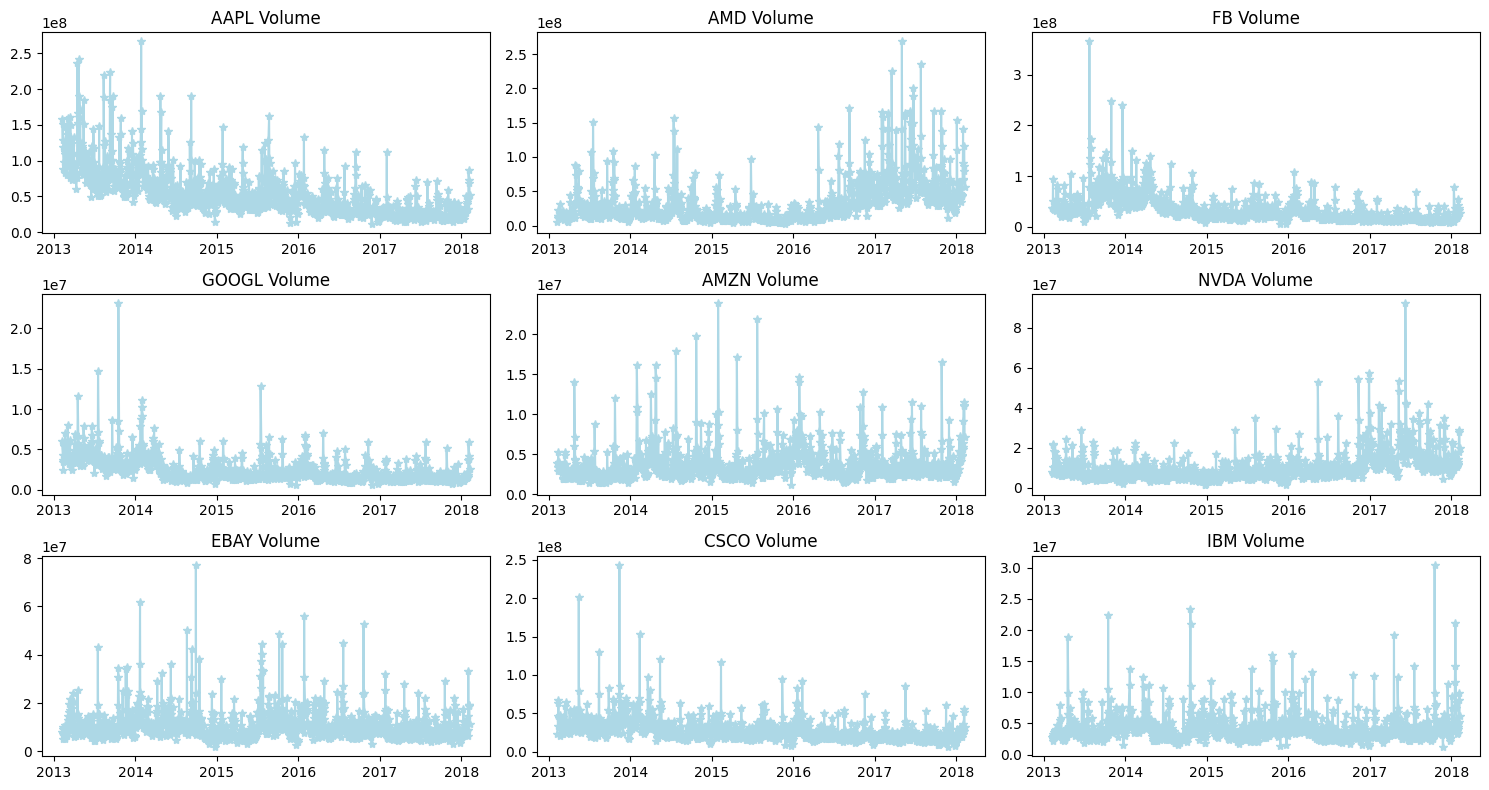

In [56]:
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
    plt.subplot(3, 3, index)
    c = data[data['Name']==company]
    plt.plot(c['date'], c['volume'], c='lightblue', label='Volume', marker='*')
    plt.title(f"{company} Volume")
    plt.tight_layout()

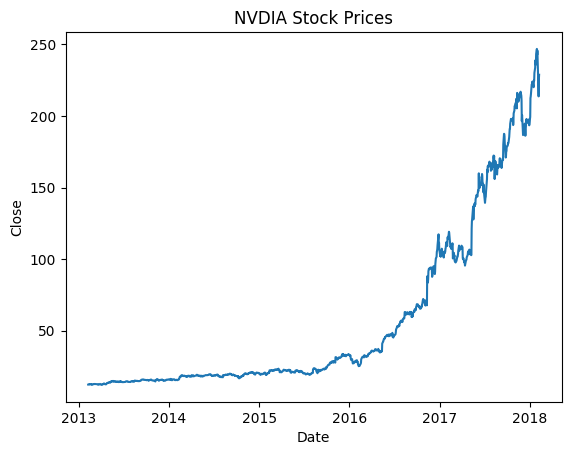

In [57]:
#now lets analyse Apple Stocks
apple = data[data['Name'] == 'NVDA']
prediction_range = apple.loc[(apple['date'] > datetime(2013, 1, 1)) & (apple['date']<datetime(2018, 1, 1))]
plt.plot(apple['date'], apple['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("NVDIA Stock Prices")
plt.show()

In [58]:
close_data = apple.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset)*0.95))
print(training)

1197


In [59]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:int(training), :]
#prepare features and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [60]:
"""
Using TensorFlow, we can easily create LSTM-gated RNN cells. LSTM is used in Recurrent Neural Networks for sequence models
and time series data. LSTM is used to avoid the vanishing gradient issue which is widely occurred in training RNN. To 
stack multiple LSTM in TensorFlow it is mandatory to use return_sequences = True. Since our data is time series varying we 
apply no activation to the output layer and it remains as 1 node. 
"""
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 64)            16896     
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(optimizer='adam', loss='mean_squared_error')
history=model.fit(x_train, y_train, epochs=10)

Epoch 1/10
36/36 [==============================] - 6s 85ms/step - loss: 0.0116
Epoch 2/10
36/36 [==============================] - 3s 89ms/step - loss: 0.0037
Epoch 3/10
36/36 [==============================] - 3s 83ms/step - loss: 0.0035
Epoch 4/10
36/36 [==============================] - 3s 89ms/step - loss: 0.0035
Epoch 5/10
36/36 [==============================] - 3s 86ms/step - loss: 0.0028
Epoch 6/10
36/36 [==============================] - 3s 85ms/step - loss: 0.0027
Epoch 7/10
36/36 [==============================] - 3s 87ms/step - loss: 0.0028
Epoch 8/10
36/36 [==============================] - 3s 87ms/step - loss: 0.0022
Epoch 9/10
36/36 [==============================] - 3s 88ms/step - loss: 0.0027
Epoch 10/10
36/36 [==============================] - 3s 82ms/step - loss: 0.0024


In [62]:
test_data = scaled_data[training - 60:, :]
x_test=[]
y_test=dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2/2 [==============================] - 1s 39ms/step
MSE 145.86837705311524
RMSE 12.077598149181618


In [63]:
print(train)

             date     open      high       low   close    volume  Name
422633 2013-02-08   12.370   12.4699   12.2900   12.37   7677336  NVDA
422634 2013-02-11   12.470   12.6350   12.3500   12.51  10207599  NVDA
422635 2013-02-12   12.395   12.5650   12.3800   12.43   6945065  NVDA
422636 2013-02-13   12.440   12.6650   12.3300   12.37  21322573  NVDA
422637 2013-02-14   12.200   12.7400   12.0500   12.73  22049335  NVDA
...           ...      ...       ...       ...     ...       ...   ...
423825 2017-11-01  209.350  209.9700  204.6000  207.20  12564446  NVDA
423826 2017-11-02  206.000  207.8100  203.6500  205.94   8557738  NVDA
423827 2017-11-03  207.200  208.6900  205.3410  208.69   8841024  NVDA
423828 2017-11-06  207.200  209.9800  206.7000  209.63   9748616  NVDA
423829 2017-11-07  210.550  212.9000  210.0556  212.03  10692542  NVDA

[1197 rows x 7 columns]


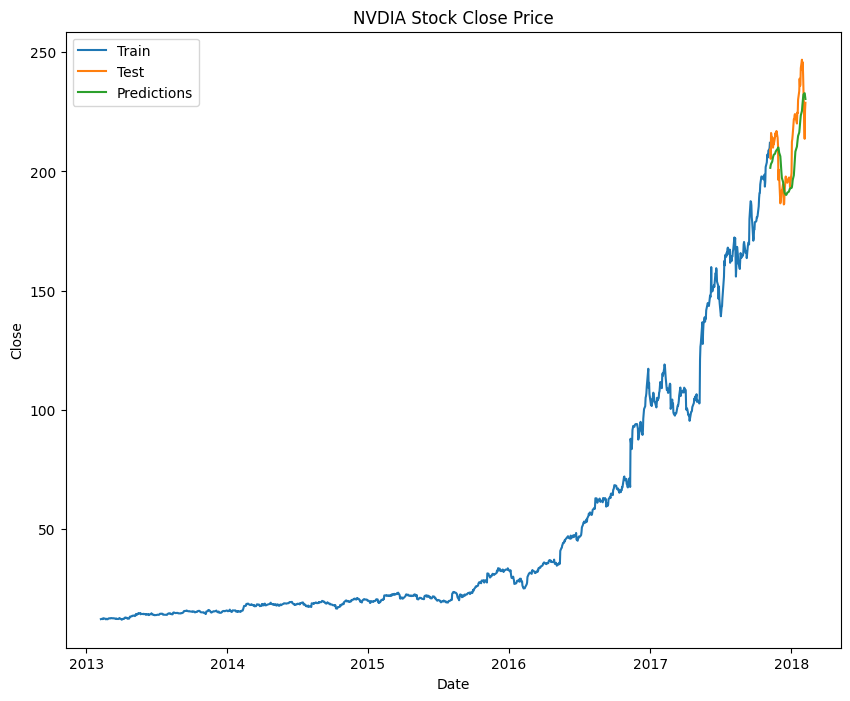

In [64]:
train = apple[:training]
test = apple[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('NVDIA Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])